In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from embedding import Embedding
from forward_kinematics import ForwardKinematic
from dynamical_system import DynamicalSystem

In [2]:
# DS parameters
config_dim = 3
K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)
# config_attractor = np.array([0.9, 1.35, 0.2])
config_attractor = np.array([.9, 0.4, -0.])

# Embedding parameters
x1 = np.array([[-0.7], [2.8], [0.]])
n_obstacles = 1
x = x1 + np.random.normal(0, 0.04, x1[np.newaxis, :].repeat(n_obstacles, 0).shape)

fk = ForwardKinematic(urdf_file='3_joints_arm.urdf')

e = Embedding(dimension=fk.model.nq, x=x, fk=fk)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.02)

In [3]:
# config_attractor = np.array([.9, 0.4, -0.])
# fig, ax = plt.subplots()
# ax.scatter(x[0], x[1], c='r', s=12)
# ax.set_aspect('equal', 'box')
# ax.set_xlim([-3.1, 3.1])
# ax.set_ylim([-0.1, 3.1])
# animate_robot(0, config_attractor[np.newaxis, :], fk, ax)

In [4]:
config_start = np.array([-0.4, 0.3, 0.])
initial_speed = np.array([0.1, -0.1, 0.])
q = config_start
dq = initial_speed
positions = []
frequencies = []
for i in range(0,2000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')

average execution frequency : 1155.3756 Hz


In [5]:
q1 = np.linspace(-np.pi, np.pi, 40)
q2 = q1.copy()
q3 = q1.copy()
gridX, gridY, gridZ = np.meshgrid(q1, q2, q3)
grid = np.column_stack((gridX.ravel(), gridY.ravel(), gridZ.ravel()))
print(grid.shape)

(64000, 3)


In [6]:
a = np.zeros((grid.shape[0], 4))
freq = []
for i, q in enumerate(grid):
    start = time.time()
    p = e.value_only(q)
    a[i] = np.array([q[0], q[1], q[2], p])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 19066.19852854748


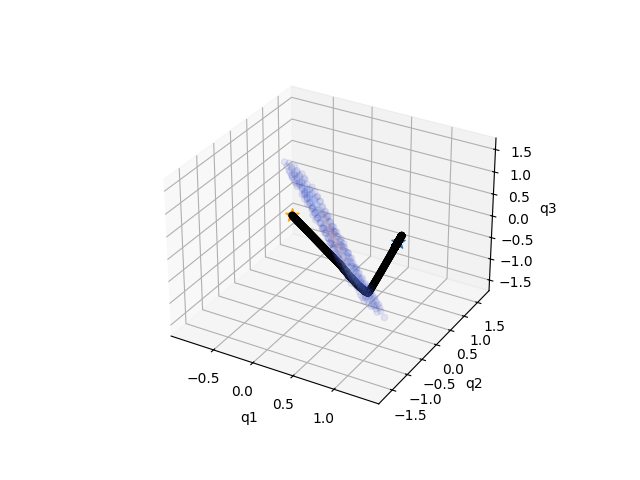

In [7]:
f = a[a[:, -1] > 0.01]
# f = a
x1 = np.unique(a[:, 0])
x2 = np.unique(a[:, 1])
x3 = np.unique(a[:, 2])
z = a[:, -1].reshape((x1.shape[0], x2.shape[0], x3.shape[0]))

ps= np.stack(positions)
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(f[:, 0], f[:, 1], f[:, 2], c=f[:, 3], cmap=cm.coolwarm, alpha=0.1)
ax.scatter(config_attractor[0], config_attractor[1], config_attractor[2], s=100, marker='*')
ax.scatter(config_start[0], config_start[1], config_start[2], s=100, marker='*', c='orange')
ax.scatter(ps[:, 0], ps[:,1], ps[:, 2], c='black')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('q3')
plt.show()

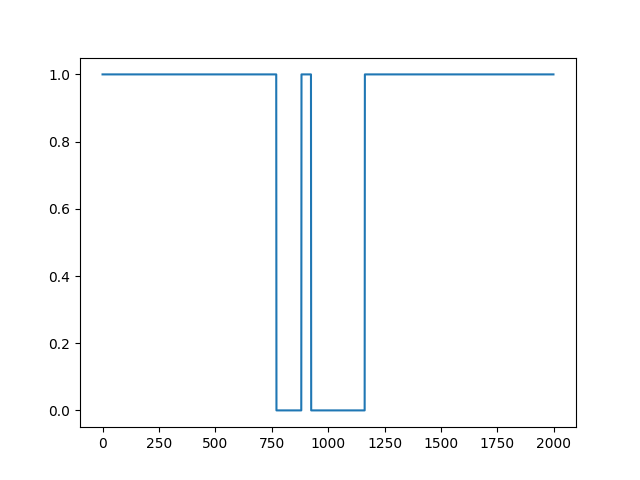

In [8]:
sigma =np.stack(ds.weight_logger)
plt.figure()
plt.plot(range(len(ds.gradient_logger)), sigma)
plt.show()

In [9]:
from itertools import combinations

def plot_coupled_embeddings(coordinates, attractor, streamlines, embedding, start):
    couples = list(combinations(np.linspace(0, coordinates.shape[1]-1, coordinates.shape[1]), r=2))
    fig, axs = plt.subplots(coordinates.shape[1], int(len(couples)/coordinates.shape[1]))
    fig.set_size_inches(7, 10)
    row = -1
    for b, couple in enumerate(couples):
        if axs.ndim == 1:
            ax = axs[b]
        else:
            ax = axs[row, b%axs.shape[1]]
        angle1 = min(int(couple[0]), int(couple[1]))
        angle2 = max(int(couple[0]), int(couple[1]))
        x = np.unique(embedding[:, angle1])
        y = np.unique(embedding[:, angle2])
        f = embedding[:, -1].reshape(tuple(x.shape[0] for _ in range(embedding.shape[1]-1)))
        dims_to_sum = tuple(map(lambda tup: tup[0], filter(lambda tup: tup[1], [(i, i not in (angle1, angle2)) for i in range(3)])))
        z = f.sum(dims_to_sum) 
        if angle1 == 0:
            ax.contourf(x, y, z, antialiased=False, alpha=0.35, cmap=cm.coolwarm)
        else:
            ax.contourf(x, y, z.T, antialiased=False, alpha=0.35, cmap=cm.coolwarm)
        if attractor is not None:
            ax.scatter(attractor[angle1], attractor[angle2], marker='*', label='target', c='navy', s=40)
        if start is not None:
            ax.scatter(start[angle1], start[angle2], marker='*', label='start', c='gold', s=40)
        if streamlines is not None:
            ax.scatter(streamlines[:, angle1], streamlines[:, angle2], label='path', c='black', s=1)
        ax.set_xlabel(f'q{angle1+1}')
        ax.set_ylabel(f'q{angle2+1}')
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([y.min(), y.max()])
        ax.legend(loc='upper right')
    fig.tight_layout()
    return axs

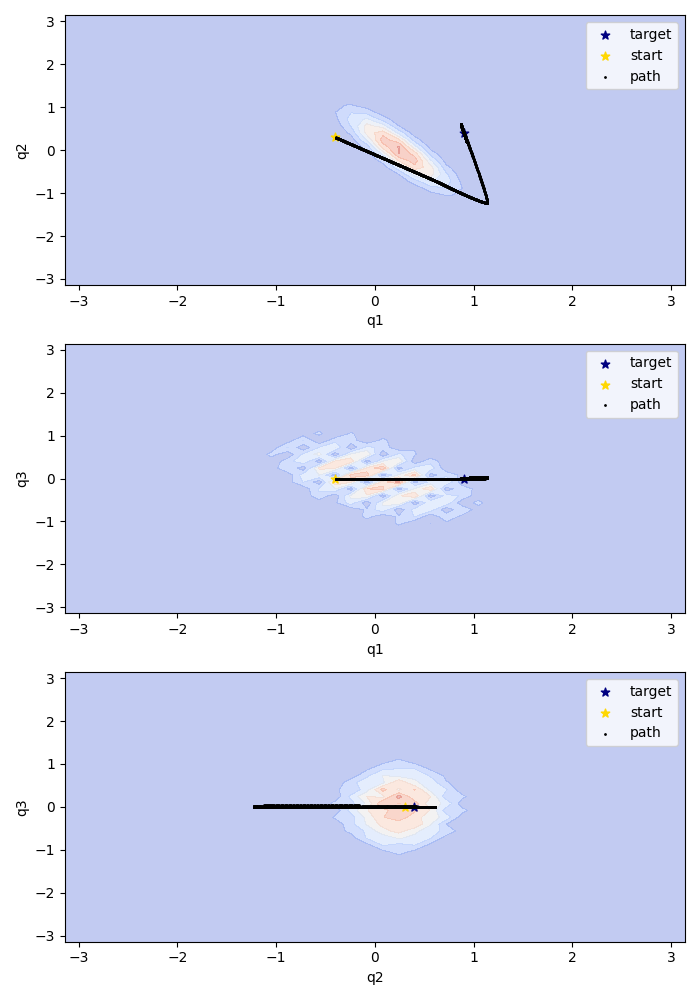

In [10]:
plot_coupled_embeddings(grid, config_attractor, ps, embedding=a, start=config_start)
plt.show()

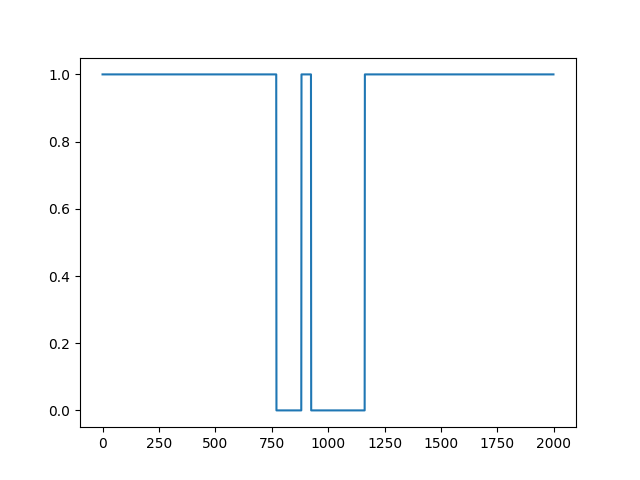

In [11]:
sigma =np.stack(ds.weight_logger)
plt.figure()
plt.plot(range(len(ds.gradient_logger)), sigma)
plt.show()

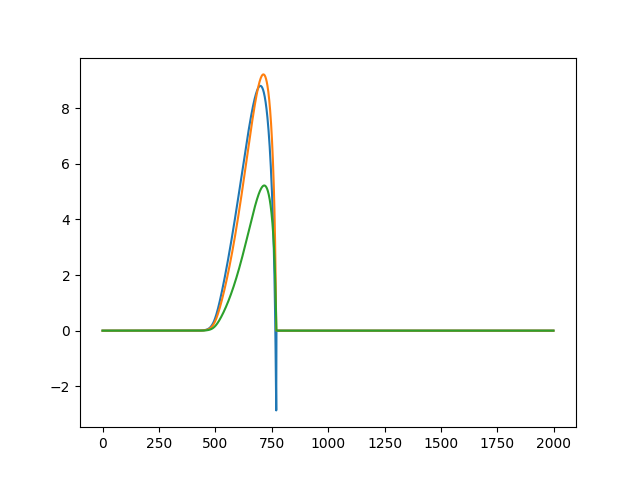

In [12]:
grad =np.stack(ds.gradient_logger)
plt.figure()
plt.plot(range(len(ds.gradient_logger)), grad[:, :, 0])
plt.plot(range(len(ds.gradient_logger)), grad[:, :, 1])
plt.plot(range(len(ds.gradient_logger)), grad[:, :, 2])
plt.show()

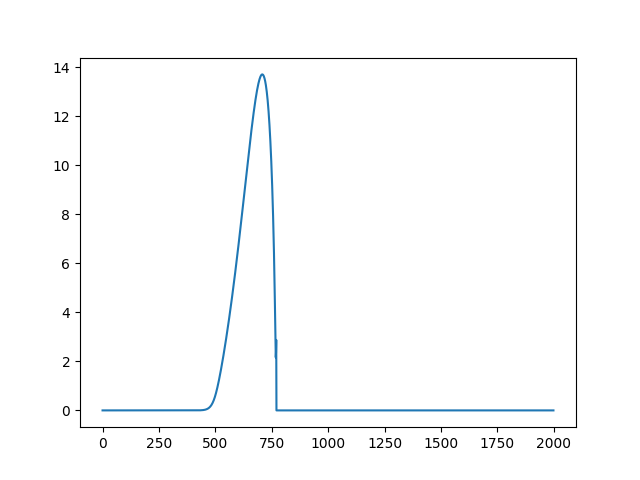

In [13]:
plt.figure()
plt.plot(range(len(ds.gradient_logger)), np.linalg.norm(grad, axis=2))
plt.show()

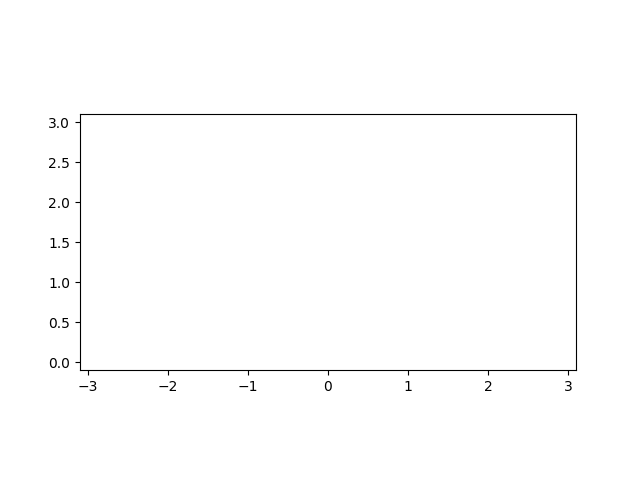

In [15]:
import pinocchio as pin
from matplotlib import animation

def animate_robot(i, configurations, fk: ForwardKinematic, ax):
    ax.clear()
    ax.set_xlim([-3.1, 3.1])
    ax.set_ylim([-0.1, 3.1])
    # ax.plot(config_attractor[0], config_attractor[1], 'y*', markersize=20, markeredgecolor='black', markeredgewidth=1)
    # for obs in [obstacle]:
    ax.scatter(x[:, 0], x[:, 1], c='r', s=12)
    q = configurations[i]
    pin.forwardKinematics(fk.model, fk.data, q)
    pin.updateFramePlacements(fk.model, fk.data)
    _ = fk(q=q, dq=np.zeros_like(q), derivation_order=0)
    mus = fk.mus
    ax.scatter(mus[:, 0], mus[:, 1], c='m', s=25)
    # Plot the target point with a border
    ee = fk.data.oMf[fk.model.getFrameId('ee')].translation
    link3 = fk.data.oMf[fk.model.getFrameId('link3')].translation
    link2 = fk.data.oMf[fk.model.getFrameId('link2')].translation
    base = fk.data.oMf[fk.model.getFrameId('link1')].translation
    # Plot the base of the robotic arm with a border
    alpha = 1.0 if i == 0 else 0.5  # Adjust opacity based on configuration index
    ax.plot(base[0], base[1], 'bo', markersize=20, alpha=alpha, markeredgecolor='black', markeredgewidth=3, zorder=10)
    ax.plot([base[0], link2[0]], [base[1], link2[1]], 'k-', linewidth=8, alpha=alpha)  # Link
    ax.plot(link2[0], link2[1], 'ko', markersize=10, markeredgecolor='black', markeredgewidth=1, zorder=10)  # Joint
    ax.plot([link2[0], link3[0]], [link2[1], link3[1]], 'k-', linewidth=8, alpha=alpha)  # Link
    ax.plot(link3[0], link3[1], 'ko', markersize=10, markeredgecolor='black', markeredgewidth=1, zorder=10)  # Joint

    # Plot the end effector of the robotic arm with a border
    ax.plot([link3[0], ee[0]], [link3[1], ee[1]], 'k-', linewidth=8, alpha=alpha)  # Link
    ax.plot(ee[0], ee[1], 'go', markersize=10, markeredgecolor='black', markeredgewidth=3, zorder=10)


fig, ax = plt.subplots()
# ax.scatter(x[0], x[1], c='r', s=12)
ax.set_aspect('equal', 'box')
ax.set_xlim([-3.1, 3.1])
ax.set_ylim([-0.1, 3.1])
dt = 0.001
step = int(np.round(0.016/dt))
ani = animation.FuncAnimation(fig, animate_robot, frames=np.arange(0, ps.shape[0], step, dtype=np.intc),fargs=(ps, fk, ax), interval=step*dt*1000, repeat=False)
# ani.save('vid.mp4')